# Notebook Overview
Please note: This notebook cannot be run on Google Colab because it uses the tkinter library, which requires screen access and user interaction (features not supported in Colab). Please run this notebook locally using Jupyter Notebook.

The Notebook covers tracking:
* Lucas-Kanade tracking 
* Kalman filter use
* Lucas-Kanade + Manual detection and temperature plotting of these results (Final chosen Model)
* Open-Cv off the shelf methods

# Imports and pre-processing steps

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
from skimage import exposure
from skimage.restoration import inpaint
from skimage.restoration import inpaint_biharmonic

from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog

import glob
import os


# Other Fence Detection methods
Initally, all 4 fence detection methods were tested with lucas-kanade tracking to see which one performed best. Temperature threshold performed best and was then tested with Kalman filtering and manual re-detecting (for harder sequences).

Run the code cells below ONLY if you want to test out the different fence detection methods, if not just run the last inpaint_biharmonic_csv(csv_file).

In [2]:
def norm(csv_file):
  thermal_image = pd.read_csv(csv_file, header=None).to_numpy()
  normalized_image = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  return normalized_image

In [3]:
#Hybrid Approach: combining temp and hough

def inpaint_biharmonic_csv(csv_file):
  #1)Temperature threshold
  thermal_image = pd.read_csv(csv_file, header=None).to_numpy()

  lower_threshold = 24
  upper_threshold = 26

  fence_mask = (thermal_image >= lower_threshold) & (thermal_image <= upper_threshold)
  fence_mask_norm = (fence_mask * 255).astype(np.uint8)
  blurred_image = cv2.GaussianBlur(fence_mask_norm, (7, 7), 0)
  canny_edges = cv2.Canny(blurred_image, 20, 120)

  #Hough line on edge detection on temperature threshold
  hough_lines = cv2.HoughLines(canny_edges, rho=1, theta=np.pi / 180, threshold=75)

  normalized_image = norm(csv_file)
  thermal_color = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

  mask = np.zeros_like(normalized_image)

  if hough_lines is not None:
      for line in hough_lines:
          rho, theta = line[0]
          #Convert from polar form to cartesian form (ρ, θ) to (x1, y1)
          a, b = np.cos(theta), np.sin(theta)
          x0, y0 = a * rho, b * rho
          x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
          x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))

          #Draw green lines onto the image
          cv2.line(thermal_color, (x1, y1), (x2, y2), (0, 255, 0), 2)
          #drawing these lines also on the mask
          cv2.line(mask, (x1, y1), (x2, y2), 255, 2)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
  #Dilating lined mask
  dilated_mask_combined = cv2.dilate(mask, kernel, iterations=1)
  #Inpaint using hybrid mask
  inpainted = inpaint.inpaint_biharmonic(normalized_image,dilated_mask_combined)
  inpainted_scaled = cv2.normalize(inpainted, None, 0, 255, cv2.NORM_MINMAX)
  inpainted_scaled = inpainted_scaled.astype(np.uint8)
  return inpainted_scaled


In [5]:
#Standard Hough Line Transform method

def inpaint_biharmonic_csv(csv_file):
  #Normalised image
  normalized_image = norm(csv_file)
  #Blur to reduce noise
  blurry = cv2.GaussianBlur(normalized_image, (7, 7), 0)

  #Canny edge detection
  edges = cv2.Canny(blurry, 20, 120) 
  lines = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=75)

  thermal_color = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

  mask_standard = np.zeros_like(normalized_image)

  if lines is not None:
    for line in lines:
      rho, theta = line[0]
      #Convert from polar form to cartesian form (ρ, θ) to (x1, y1)
      a, b = np.cos(theta), np.sin(theta)
      x0, y0 = a * rho, b * rho
      x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
      x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))

      #Draw green lines onto the image
      cv2.line(thermal_color, (x1, y1), (x2, y2), (0, 255, 0), 2)
      #drawing these lines also on the mask
      cv2.line(mask_standard, (x1, y1), (x2, y2), 255, 2)


  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
  #Dilate detected lines
  dilated_mask_standard = cv2.dilate(mask_standard, kernel, iterations=1)

  #Inpaint using hough mask
  inpainted = inpaint.inpaint_biharmonic(normalized_image,dilated_mask_standard)
  inpainted_scaled = cv2.normalize(inpainted, None, 0, 255, cv2.NORM_MINMAX)
  inpainted_scaled = inpainted_scaled.astype(np.uint8)
  #return inpainted frame
  return inpainted_scaled


In [6]:
#Probability Hough Line transform:
def inpaint_biharmonic_csv(csv_file):
  normalized_image = norm(csv_file)
  blurred_image = cv2.GaussianBlur(normalized_image, (7, 7), 0)
  edges = cv2.Canny(blurred_image, threshold1=30, threshold2=180)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  #Refining hough probability mask
  closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

  lines = cv2.HoughLinesP(closed_edges, rho=1, theta=np.pi / 180, threshold=50, minLineLength=0, maxLineGap=10000)

  image_showing_lines = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)
  mask_prob = np.zeros_like(normalized_image)

  for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(mask_prob, (x1, y1), (x2, y2), 255, 3)
      cv2.line(image_showing_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

  dilated_mask_hough_prob = cv2.dilate(mask_prob, kernel, iterations=1)
  #Inpaint
  inpainted = inpaint.inpaint_biharmonic(normalized_image,dilated_mask_hough_prob)
  inpainted_scaled = cv2.normalize(inpainted, None, 0, 255, cv2.NORM_MINMAX)
  inpainted_scaled = inpainted_scaled.astype(np.uint8)
  #Return inpainted image based on Prob. hough fence detection
  return inpainted_scaled




# Temperature Inpainting (Rest of code)

In [7]:
#Temperature thresholding and biharmonic inpainting method
#used for a single frame
def inpaint_biharmonic_csv(csv_img):
  data = pd.read_csv(csv_img, header=None)
  thermal_image = data.to_numpy()
  lower_threshold = 24
  upper_threshold = 28

  #Creating mask of fence: where the temperature is within the threshold will be white
  fence_mask = (thermal_image >= lower_threshold) & (thermal_image <= upper_threshold)

  #Dilating that fence-mask + Normalise:
  fence_mask = fence_mask.astype(np.uint8) * 255
  kernel = np.ones((3, 3))
  dilated_mask_temp = cv2.dilate(fence_mask, kernel, iterations=3)
  #Inpainting
  inpainted_image_temp = inpaint.inpaint_biharmonic(thermal_image, dilated_mask_temp )
  #Normalise inpaint (Biharmonic output ranges in temp. range)
  inpainted_scaled = cv2.normalize(inpainted_image_temp, None, 0, 255, cv2.NORM_MINMAX)
  inpainted_scaled = inpainted_scaled.astype(np.uint8)

  return inpainted_scaled

So what the code above is doing is:
1) Taking Fence mask which will be boolean (True or false) for each pixel that is within the temperature range/is a fence
2) Making it np.uint8 which makes them 0 or 1 values, and then multiplying it by 255
3) So true values(1) will become 255 (white fence mask)


* skimage.restoration.inpaint_biharmonic will have the same numerical range and data type as the input image. If your input image consists of floating-point temperature values, the inpainted output will also be in floating-point temperature values.
* Lucas-Kanade assume 8-bit grayscale images (0-255 intensity values). Computes optical flow based on intensity differences in grayscale frames. Requires them to be in grayscale aswell (single channel). 

-> Therefore, after inpainting we need to normalise the image to 0-255 for lucas-kanade tracking.

In [8]:
#Get coordinates of point clicked by the users
#Works so that only will take the first click you make
#store them in selected_coordinates
#return's the x and y coordinates of the selected point (as tuple)

def get_clicked_coordinates(image):
    #Check to make image into Numpy array 
    if isinstance(image, np.ndarray):
        image = np.clip(image, 0, 255).astype(np.uint8)  
        image = Image.fromarray(image)

    #To store coordinates
    selected_coordinates = {"x": None, "y": None}

    #Create Tkinter Object
    window = tk.Tk()
    window.title("Click Once to Select a Point & Close Window")

    frame = tk.Frame(window)
    frame.pack(fill=tk.BOTH, expand=tk.YES)

    canvas = tk.Canvas(frame, width=image.width, height=image.height)
    canvas.pack(fill=tk.BOTH, expand=tk.YES)

    tk_image = ImageTk.PhotoImage(image)
    canvas.create_image(0, 0, anchor=tk.NW, image=tk_image)

    #Capture's only the first click function
    def get_coordinates(event):
        #Only stores first coordinates that were clicked
        if selected_coordinates["x"] is None and selected_coordinates["y"] is None: 
            selected_coordinates["x"] = event.x
            selected_coordinates["y"] = event.y

            #Shows coordinates selected
            #Horizontal line
            canvas.create_line(event.x - 10, event.y, event.x + 10, event.y, fill="red", width=2)
            #Vertical line  
            canvas.create_line(event.x, event.y - 10, event.x, event.y + 10, fill="red", width=2)  
            
            print(f"Selected Coordinates: ({event.x}, {event.y})")

    #When click anywhere on canvas, it will trigger the get_coordinate function
    #to store the coordinates
    canvas.bind("<Button-1>", get_coordinates)

    #User has to closer the window (had issue if done automatic)
    window.mainloop()

    if selected_coordinates["x"] is not None and selected_coordinates["y"] is not None:
        return (selected_coordinates["x"], selected_coordinates["y"])
    else:
        print("No point selected.")
        return None


# Lucas-Kanade Tracking

In [9]:
#Lucas-Kanade tracking based on inital manual detection

#Path to example of test sequence (tested actually 3 sequences, this is just one of them)
##This test sequence/video was particularly difficult (movement, lots of obstruction), see examples of other videos where it showed success
csv_folder_path= "test_sequence_for_tracking"
csv_files = sorted(glob.glob(os.path.join(csv_folder_path, '*.csv')))
#Throws error if folder does not exist
if len(csv_files) == 0:
    raise Exception("No CSV files found in the specified folder.")

#Outputs video in desktop, name of video:
output_video_path = os.path.join(os.path.expanduser("~"), "Desktop", "output_video.mp4") 

#First frame needs to be inpainted
first_csv = csv_files[0]
#Inpainting it (method inpaint_biharmonic_csv takes image, detects fence, inpaints )
first_frame_inpaint = inpaint_biharmonic_csv(first_csv)
#extract the frame's height and width
frame_height, frame_width = first_frame_inpaint.shape

#VideoWriter is used to put frames back together
#30 Frames per second
#Format: mp4
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#Stating the parameters: where it outputs, using VideoWriter, 30 frames per second, width and heigt of video
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

#Custom points we are assigning (based on where I see the nose)
#using earlier function to collect user's coordinates
image = Image.fromarray(first_frame_inpaint)
x,y = get_clicked_coordinates(image)
initial_point = np.array([[x,y]], dtype=np.float32) 

#Reshaping for algorithm
p0 = initial_point.reshape(-1, 1, 2)
#Inpainted first frame
prev_gray = first_frame_inpaint.copy()

#Annotate the first frame with the tracking point
#Lucas-kanade takes grayscale image: Color_Gray2BGR
first_frame_bgr = cv2.cvtColor(first_frame_inpaint, cv2.COLOR_GRAY2BGR)
#making the circle/eclipse ontop of the pixel, Green (255) and only border (+1) if filled (-1), to make thicker increase last number
cv2.circle(first_frame_bgr, (int(initial_point[0, 0]), int(initial_point[0, 1])), 10, (0, 255, 0), 3) 

#For comparing frames (we add writing of the frame to the video)
frame_idx = 0
cv2.putText(first_frame_bgr, f"Frame: {frame_idx}", (10, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
out.write(first_frame_bgr)


#Add first frame to video sequence output
out.write(first_frame_bgr)

#Lucas–Kanade Optical Flow Parameters
lk_params = dict(
    winSize  = (15, 15),
    maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

#For each frame after the first one
for csv_file in csv_files[1:]:
    #Inpaint it
    inpainted_frame = inpaint_biharmonic_csv(csv_file)
    #Copy the inpainted verision
    current_frame_gray = inpainted_frame.copy()

    # Compute optical flow: prev_gray is first frame the first time
    #prev_Gray will be the previous frame any other time
    #frame_gray is the current/new frame
    #lk_params Parameters for tracking (above)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, current_frame_gray, p0, None, **lk_params)
    #p1: new position of the input points
    #st: 1 if sucess, 0 if tracking failed for that points
    #err: is the error value indicating how good the match was for each tracked point 

    #Check tracking is sucessful (if not break-out o floop)
    if p1 is None or st[0][0] == 0:
      #if the next tracked point is none or Status flag (1 = successfully tracked, 0 = lost)
        print(f"Tracking lost at frame index {frame_idx}.")
        break

    #New nose tip point
    new_point = p1[0][0]

    #Write where the new nose point is with colors
    frame_bgr = cv2.cvtColor(inpainted_frame, cv2.COLOR_GRAY2BGR)
    cv2.circle(frame_bgr, (int(new_point[0]), int(new_point[1])), 10, (0, 255, 0), 3) #can also change thickness by chaning the 1 to higher
    cv2.putText(frame_bgr, f"Frame: {frame_idx}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    #Add the annoted frame to write to create video after
    out.write(frame_bgr)

    #Update previous frame to current for the next iteration
    prev_gray = current_frame_gray.copy()
    #Update the previous point to current point for the next iteration
    p0 = p1.copy()

    frame_idx += 1

#Release the video at the space specified
out.release()
print("Tracking complete. Output video saved at:", output_video_path)


Selected Coordinates: (270, 144)
Tracking complete. Output video saved at: /Users/iadician/Desktop/output_video.mp4


# kalman Filter
Testing out Kalman filter on our temperature fence detection with inpainting. Visually on output video, if there is both a green and red circle, the algorthm is using Lucas-kanade. If lucas-kanade produces too high of an optical flow error (>5), then it will use Kalman and the nose circle will be just red. Kalman makes future movements based on past frame movements.

In [10]:
#Same test file as before
csv_folder_path = "test_sequence_for_tracking"
csv_files = sorted(glob.glob(os.path.join(csv_folder_path, '*.csv')))
if len(csv_files) == 0:
    #in case the file is not found 
    raise Exception("No CSV files found in the specified folder.")

#Output video on desktop and calls it kalman_filter
output_video_path = os.path.join(os.path.expanduser("~"), "Desktop", "kalman_filter.mp4") 

#Processes the first frame
first_csv = csv_files[0]
first_frame_inpaint = inpaint_biharmonic_csv(first_csv)
frame_height, frame_width = first_frame_inpaint.shape

fps = 30  
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

#Get initial nose point using manual click
image = Image.fromarray(first_frame_inpaint)
x, y = get_clicked_coordinates(image)
initial_point = np.array([[x, y]], dtype=np.float32) 
p0 = initial_point.reshape(-1, 1, 2)
prev_gray = first_frame_inpaint.copy()

# Draw first nose point/ circle on frame and save it
first_frame_bgr = cv2.cvtColor(first_frame_inpaint, cv2.COLOR_GRAY2BGR)
cv2.circle(first_frame_bgr, (int(initial_point[0, 0]), int(initial_point[0, 1])), 10, (0, 255, 0), 1)

frame_idx = 0
#Overlay the frame number in red
cv2.putText(first_frame_bgr, f"Frame: {frame_idx}", (10, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
out.write(first_frame_bgr)

#Kalman Filter:
kalman = cv2.KalmanFilter(4, 2)
#State vector of length 4 
#Measurement vector of length 2
#->[x,y,vx, vy] x and y points and the points direction movmenet (velocity)
#we only get the observed point (2 elements) not how fast they are moving (We calculate that with the filter)
kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                    [0, 1, 0, 1],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]], dtype=np.float32)

#x = x + vx
#y = y + vy
#vx and yx stays the same
kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                     [0, 1, 0, 0]], dtype=np.float32)
#->Stating we can only measure x and y
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 1e-4 #adds a little noise to the prediction step (not fully trust kalman)
kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 1e-1 #adds a little noise to lucas-kanade measurements (not fully trust them)
kalman.errorCovPost = np.eye(4, dtype=np.float32) #Treat each part iwth inital same certainty
kalman.statePost = np.array([[initial_point[0, 0]], #x
                             [initial_point[0, 1]], #y
                             [0], #vx
                             [0]], dtype=np.float32) #vy
#->Initally no movement: statepost

lk_params = dict(
    winSize  = (15, 15),
    maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

#Defining Thresholds
measurement_threshold = 20 #how different kalham filter to lucas-kanade
flow_error_threshold = 5 #How wrong lucas-kanade can be

for csv_file in csv_files[1:]:
    inpainted_frame = inpaint_biharmonic_csv(csv_file)
    frame_gray = inpainted_frame.copy()

    #Calculate optical flow using Lucas–Kanade method
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, p0, None, **lk_params)
    #err is Photometric error 

    #Based on new frame movement, make a kalman prediction
    prediction = kalman.predict()
    pred_x, pred_y = prediction[0, 0], prediction[1, 0]

    #not using the Kalman measurements by default
    LK_measurement_used = False
    lucas_point = None

    if p1 is not None and st[0][0] == 1:
        lucas_point = p1[0][0]
        l_k_measurement = np.array([[np.float32(lucas_point[0])],
                                [np.float32(lucas_point[1])]])

        #Test 1: Check if the optical flow error is too high
        if err is not None and err[0][0] >= flow_error_threshold:
            #Get the kalman prediction 
            kalman_point = (pred_x, pred_y)
            p0 = np.array([[[pred_x, pred_y]]], dtype=np.float32)
            print(f"Frame {frame_idx}: High optical flow error ({err[0][0]:.2f}). Using Kalman prediction.")
        else:
            #Test 2: Check if the Lucas–Kanade measurement deviates too much from Kalman prediction
            diff = np.linalg.norm(l_k_measurement - prediction[0:2]) 
            if diff >= measurement_threshold:
                #If deviates too much use kalman prediction
                kalman_point = (pred_x, pred_y)
                p0 = np.array([[[pred_x, pred_y]]], dtype=np.float32)
                print(f"Frame {frame_idx}: Measurement deviates too much (diff = {diff:.2f}). Using Kalman prediction.")
            else:
                #Test 3: Lucas–Kanade measurement is correct, use it to correct the Kalman filter
                estimated = kalman.correct(l_k_measurement)
                kalman_point = (estimated[0, 0], estimated[1, 0])
                p0 = p1.copy()
                LK_measurement_used = True
    else:
        #Lucas–Kanade tracking lost
        #Use Kalman prediction
        kalman_point = (pred_x, pred_y)
        p0 = np.array([[[pred_x, pred_y]]], dtype=np.float32)
        print(f"Frame {frame_idx}: Lucas–Kanade tracking lost. Using Kalman prediction.")

    #To add new frame, make it into colour
    frame_colour = cv2.cvtColor(inpainted_frame, cv2.COLOR_GRAY2BGR)

    #Only draw lucas-kanade if Kalman was not used
    if LK_measurement_used and lucas_point is not None:
        cv2.circle(frame_colour, (int(lucas_point[0]), int(lucas_point[1])), 10, (0, 255, 0), 1)

    #Draw the Kalman Filter prediction in red anyways (even if lucas-kanade is used)
    cv2.circle(frame_colour, (int(kalman_point[0]), int(kalman_point[1])), 10, (0, 0, 255), 1)

    #Frame number (in red)
    cv2.putText(frame_colour, f"Frame: {frame_idx}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    out.write(frame_colour)
    prev_gray = frame_gray.copy()
    frame_idx += 1

out.release()
print("Tracking complete. Output video saved at:", output_video_path)


Selected Coordinates: (272, 141)
Frame 5: High optical flow error (7.04). Using Kalman prediction.
Frame 31: High optical flow error (5.96). Using Kalman prediction.
Frame 43: High optical flow error (6.71). Using Kalman prediction.
Frame 44: High optical flow error (5.16). Using Kalman prediction.
Frame 46: High optical flow error (5.17). Using Kalman prediction.
Frame 47: Measurement deviates too much (diff = 24.29). Using Kalman prediction.
Frame 64: Measurement deviates too much (diff = 20.97). Using Kalman prediction.
Tracking complete. Output video saved at: /Users/iadician/Desktop/kalman_filter.mp4


# Manual Re-detection
Since Kalman filter didn't help, we can just set an error threshold for lucas-kanade and when the error is too high, manually re-initialise it.
The code is also doing another thing; it is storing all the minium and maximum values for each frame. Since we are normalising each frame independently, when we then exact the temperature values from the tracking (undo normalisation), to get the original temperatures back we need to have the original min max values.

The alternative approach would be global normalisation (not implemented here).

In [11]:
csv_folder_path= "test_sequence_for_tracking"
csv_files = sorted(glob.glob(os.path.join(csv_folder_path, '*.csv')))
if len(csv_files) == 0:
    #incase folder doesn't exist error
    raise Exception("No CSV files found in the specified folder.")

#Name of path where the output video will be
output_video_path = os.path.join(os.path.expanduser("~"), "Desktop", "temp_Tracking_test.mp4") 

#First frame needs to be inpainted
#First Frame
first_csv = csv_files[0]
#Inpainting it (method inpaint_biharmonic_csv takes image, detects fence, inpaints )
first_frame_inpaint = inpaint_biharmonic_csv(first_csv)
#extract the frame's height and width
frame_height, frame_width = first_frame_inpaint.shape

#VideoWriter is used to put frames back together
#30 Frames per second
#Format: mp4
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#Stating the paramters: where it outputs, using VideoWriter, 30 frames per second, width and height of video
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

image = Image.fromarray(first_frame_inpaint)
#Manually getting this nose coordinates for the first frame, calls get clicked coordinates
x,y = get_clicked_coordinates(image)
#stores coordinates in inital point
initial_point = np.array([[x,y]], dtype=np.float32) 

#Reshaping for LK algorithm
p0 = initial_point.reshape(-1, 1, 2)
prev_gray = first_frame_inpaint.copy()

#Annotate the first frame with the tracking point
#To annoate nose ciricle in a colour, must convert grayscale to coloured
first_frame_bgr = cv2.cvtColor(first_frame_inpaint, cv2.COLOR_GRAY2BGR)
#making the circle/eclipse ontop of the pixel, Green (255) and only border (+1), if filled (-1), can adjust size thickness
#1 is good but bigger for figures is better
cv2.circle(first_frame_bgr, (int(initial_point[0, 0]), int(initial_point[0, 1])), 10, (0, 255, 0), 2)
#Add first frame to video sequence output
out.write(first_frame_bgr)

#Lucas–Kanade Optical Flow Parameters
lk_params = dict(
    winSize  = (15, 15),
    maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

error_threshold = 5 # tested 10 (higher threshold, but 5 works best)
frame_idx = 0
#tracked_coordinates is a list that tracks all nose coordinates for later temperature plotting
tracked_coordinates = [(int(initial_point[0, 0]), int(initial_point[0, 1]))] 
#Stores inapitned nose values for those coordinates for later temp. plotting
pixel_values = [first_frame_inpaint[int(initial_point[0, 1]), int(initial_point[0, 0])]]

#For each frame after the first one
for csv_file in csv_files[1:]:
    # Inpaint current frame
    inpainted_frame = inpaint_biharmonic_csv(csv_file)
    frame_gray = inpainted_frame.copy()

    #Compute optical flow from prev_gray to current frame
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, p0, None, **lk_params)

    #Check if tracking failed or error exceeds threshold
    if p1 is None or st[0][0] == 0 or (err is not None and err[0][0] > error_threshold):
        print(f"Tracking lost at frame index {frame_idx}.")
        print(f"Tracking lost or error ({err[0][0] if err is not None else 'N/A'}) exceeded threshold at frame index {frame_idx}.")
        print("Please re-detect the nose by clicking on the image.")
        
        #If residual eror is > 5 then re-call get_clicked_coordinates function to manually re-initalise the points
        image_for_click = Image.fromarray(frame_gray)
        new_coords = get_clicked_coordinates(image_for_click)
        re_point = np.array([[new_coords]], dtype=np.float32)
        new_point = re_point.copy()
    else:
        #If tracking was good, then keep the point tracked: (no need for update)
        new_point = p1 
    
    #Draw the new point on the frame
    pt = new_point[0][0] 
    #Store coordinates
    tracked_coordinates.append((int(pt[0]), int(pt[1])))
    #Store inpainted nose value at those coordinates
    pixel_value = frame_gray[int(pt[1]), int(pt[0])]
    pixel_values.append(pixel_value)


    frame_colour = cv2.cvtColor(inpainted_frame, cv2.COLOR_GRAY2BGR)
    cv2.circle(frame_colour, (int(pt[0]), int(pt[1])), 10, (0, 255, 0), 1)
    cv2.putText(frame_colour, f"Frame: {frame_idx}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    out.write(frame_colour)

    #Update the previous frame and tracking point for the next iteration
    prev_gray = frame_gray.copy()
    p0 = new_point.copy()

    frame_idx += 1


#Release the video
out.release()
print("Tracking complete. Output video saved at:", output_video_path)


Selected Coordinates: (270, 141)
Tracking lost at frame index 5.
Tracking lost or error (7.255000114440918) exceeded threshold at frame index 5.
Please re-detect the nose by clicking on the image.
Selected Coordinates: (284, 148)
Tracking lost at frame index 6.
Tracking lost or error (5.089722156524658) exceeded threshold at frame index 6.
Please re-detect the nose by clicking on the image.
Selected Coordinates: (291, 151)
Tracking lost at frame index 11.
Tracking lost or error (5.657777786254883) exceeded threshold at frame index 11.
Please re-detect the nose by clicking on the image.
Selected Coordinates: (308, 148)
Tracking lost at frame index 17.
Tracking lost or error (16.685693740844727) exceeded threshold at frame index 17.
Please re-detect the nose by clicking on the image.
Selected Coordinates: (302, 150)
Tracking lost at frame index 22.
Tracking lost or error (9.009166717529297) exceeded threshold at frame index 22.
Please re-detect the nose by clicking on the image.
Selected

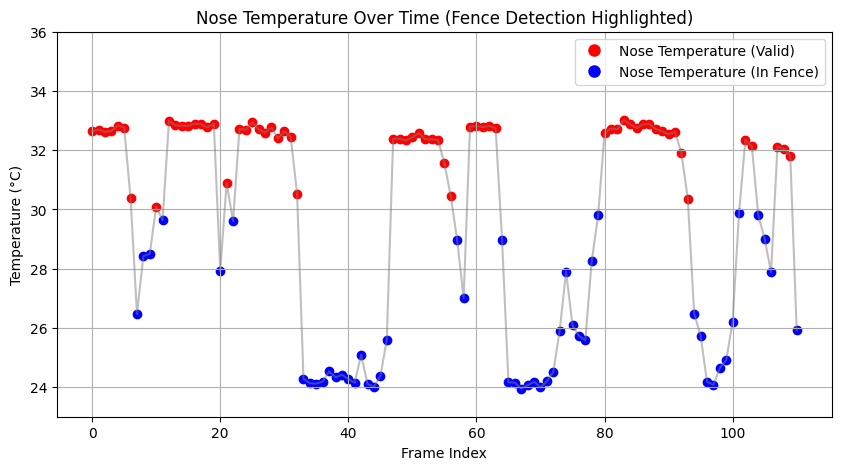

In [12]:
#Used to determine if it is a fence
upper_threshold = 29.9

real_temperatures = []
colors = []

#For each csv frame in csv file doler
for i, csv_file in enumerate(csv_files[:len(tracked_coordinates)]):
    #Load csv frame
    thermal_frame = np.loadtxt(csv_file, delimiter=",") 
    #load it's corresponding tracked coordinates 
    x, y = tracked_coordinates[i]  
    #Extract the real temperature at that coordinate
    temp_value = thermal_frame[y, x]  
    #add that to the list
    real_temperatures.append(temp_value)

    #Assign color: blue if in fence range, red otherwise
    if temp_value <= upper_threshold:
        colors.append('b')  
    else:
        colors.append('r') 


plt.figure(figsize=(10, 5))
#Assining each nose point it's corresponding colour (depending of it met threshold or not)
for i in range(len(real_temperatures)):
    plt.scatter(i, real_temperatures[i], color=colors[i])

#Connect each point with gray line
plt.plot(range(len(real_temperatures)), real_temperatures, linestyle='-', color='gray', alpha=0.5)

#Legend
red_marker = mlines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=8, label="Nose Temperature (Valid)")
blue_marker = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=8, label="Nose Temperature (In Fence)")

plt.ylim(23, 36)
plt.xlabel("Frame Index")
plt.ylabel("Temperature (°C)")
plt.title("Nose Temperature Over Time (Fence Detection Highlighted)")
plt.legend(handles=[red_marker, blue_marker]) 
plt.grid()
plt.savefig("nose_temperature_plot.png", dpi=600, bbox_inches='tight')
plt.show()


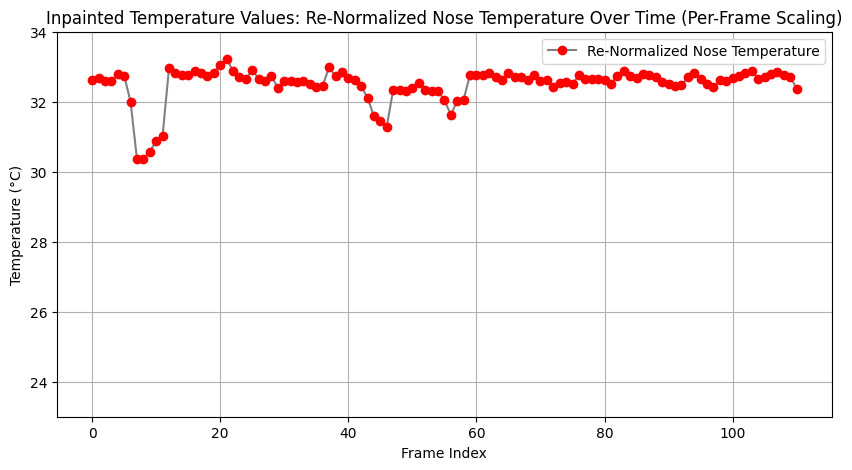

In [13]:
#Test: number of pixel values = the number of frames
if len(pixel_values) != len(csv_files):
    raise Exception(f"Mismatch: {len(pixel_values)} pixel values vs {len(csv_files)} frames.")

#List to store re-normalized temperature values
inpainted_Temps = []

for i, csv_file in enumerate(csv_files):
    #For each frame in csv file
    thermal_frame = np.loadtxt(csv_file, delimiter=",")
    #Get it original temperature min and max
    temp_min = np.min(thermal_frame)
    temp_max = np.max(thermal_frame)

    #Get the nose inpainted value
    grayscale_pixel = pixel_values[i]

    #Reverse normalization: Convert grayscale (0-255) back to temperature for that nose inpainted value
    temperatu_value = ((grayscale_pixel / 255) * (temp_max - temp_min)) + temp_min

    #Store the re-normalized temperature value
    inpainted_Temps.append(temperatu_value)


plt.figure(figsize=(10, 5))
plt.plot(range(len(inpainted_Temps)), inpainted_Temps, marker='o', linestyle='-', color='gray', markeredgecolor='red', markerfacecolor ="red" ,label="Re-Normalized Nose Temperature")

plt.ylim(23, 34) 
plt.xlabel("Frame Index")
plt.ylabel("Temperature (°C)")
plt.title("Inpainted Temperature Values: Re-Normalized Nose Temperature Over Time (Per-Frame Scaling)")
plt.legend()
plt.grid()
plt.savefig("Inpainted_values_plot.png", dpi=600, bbox_inches='tight')
plt.show()

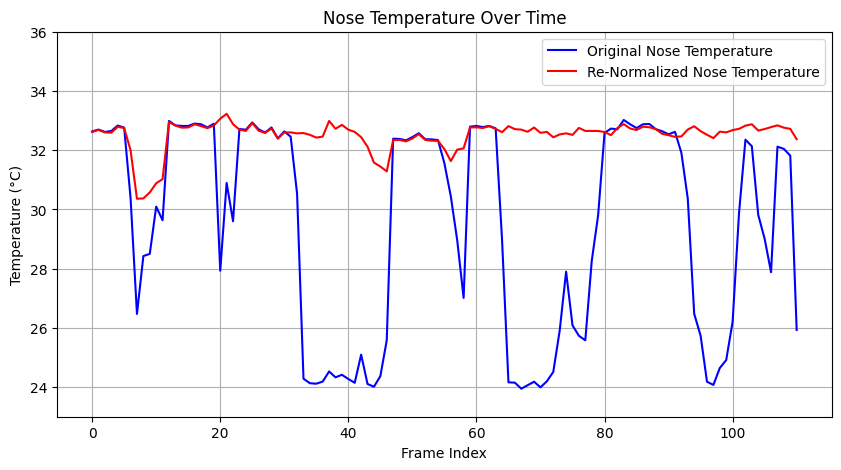

In [14]:
#Plotting both curves one on top of the other
inpainted_Temps = []
real_temperatures = []

for i, csv_file in enumerate(csv_files[:len(tracked_coordinates)]):
    #for each frame

    #get real nose value
    thermal_frame = np.loadtxt(csv_file, delimiter=",") 
    x, y = tracked_coordinates[i] 
    temp_value = thermal_frame[y, x] 
    real_temperatures.append(temp_value)

    #Re-normalise inpainted value
    temp_min = np.min(thermal_frame)
    temp_max = np.max(thermal_frame)
    grayscale_pixel = pixel_values[i]
    temperature_value = ((grayscale_pixel / 255) * (temp_max - temp_min)) + temp_min
    inpainted_Temps.append(temperature_value)

#Plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(real_temperatures)), real_temperatures, linestyle='-', color='blue', label='Original Nose Temperature')
plt.plot(range(len(inpainted_Temps)), inpainted_Temps, linestyle='-', color='red', label='Re-Normalized Nose Temperature')

plt.ylim(23, 36)
plt.xlabel("Frame Index")
plt.ylabel("Temperature (°C)")
plt.title("Nose Temperature Over Time")
plt.legend()
plt.grid()
plt.savefig("Super-imposed-plot.png", dpi=600, bbox_inches='tight')
plt.show()


# Open-CV off-the-shelves Method
In the cell below is the code to create videos for the tracking methods that were taken directly from Open-Cv Library 